# Исследование тенденций в игровой индустрии 
Исследование проводится для интернет-магазина "Стримчик". В рамках работы планируется изучить данные о продажах игр, оценках пользователей и экспертов для поиска закономерностей, определяющих успешность игр. Выявленные закономерности будут использованы при планировании будущей работы магазина.
Исследование состоит из следующих этапов:
1. Загрузка и предобработка данных;
2. Исследовательский анализ имеющихся данных
    1. Определение актуальности данных;
    2. Анализ существующих платформ;
    3. Анализ распределения игр по жанрам.
3. Составление портрета пользователя для каждого региона
4. Проверка гипотез
5. Общий вывод

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Шаг. Загрузка и предобработка данных

In [2]:
def check_df (df):

    display(df.info())

    display(df.head())

In [3]:
df = pd.read_csv('/datasets/games.csv')

In [4]:
check_df(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


При первоначальном анализе можно обнаружить пропуски в столбцах critic_score, user_score, rating. Пропуски в данных столбцах не представляется возможным заполнить из-за их участия в дальнейших расчетах и специфической форме, все эти столбцы содержат оценки игр, которые нельзя заменить просто подставив среднее или медианное значение без вреда для выборки.

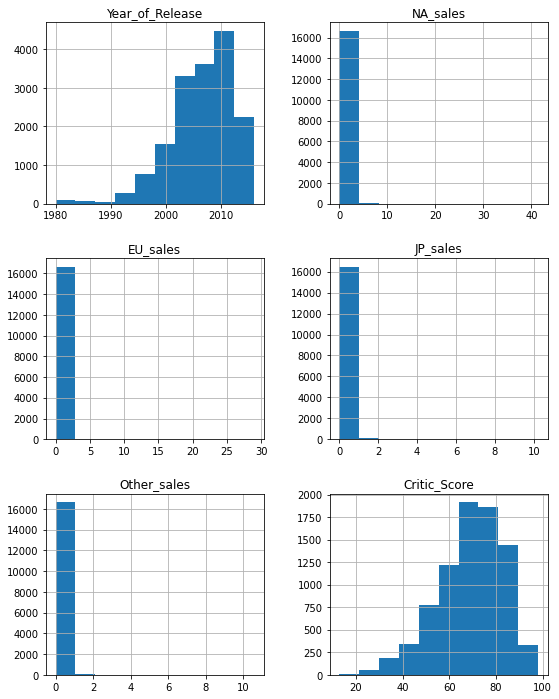

In [5]:
df.hist(figsize=(9,12))
plt.show()

In [6]:
df = df.rename(columns={'Name': 'name',
                        'Platform': 'platform',
                        'Year_of_Release':'year_of_release',
                        'Genre': 'genre',
                        'NA_sales': 'na_sales',
                        'EU_sales': 'eu_sales',
                        'JP_sales': 'jp_sales',
                        'Other_sales': 'other_sales',
                        'Critic_Score': 'critic_score',
                        'User_Score': 'user_score',
                        'Rating': 'rating'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Изменим тип данных в столбцах year_of_release на int64, т.к. год издания не может быть вещественным числом, user_score на float32 т.к. оценка происходит в вещественных числах, а тип object в дальнейшем может помешать расчетам.

In [7]:
try:
    df.astype({'user_score':'float32'})
except Exception as e: print(e)

could not convert string to float: 'tbd'


Среди оценок встречается строка tbd, этa аббревиатура означает to be determined, оценку еще не поставили, заменим эти значения на пропуски.

In [8]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
try:
    df = df.astype({'user_score':'float32'})
except Exception as e: print(e)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float32
 10  rating           9949 non-null   object 
dtypes: float32(1), float64(6), object(4)
memory usage: 1.3+ MB


In [10]:
# Добавим столбец с суммарными продажами по всем регионам
df['global_sales'] = (df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales'])
check_df(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float32
 10  rating           9949 non-null   object 
 11  global_sales     16715 non-null  float64
dtypes: float32(1), float64(7), object(4)
memory usage: 1.5+ MB


None

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [11]:
display(df.loc[df['name'].isna() == True])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


In [12]:
display(df.loc[df['year_of_release'].isna() == True])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.24
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,3.50
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,3.06
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.53
...,...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+,0.01
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T,0.01
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M,0.01
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


Пропуски в столбцах name и genre обусловлены двумя играми на платформе GEN, их год выпуска 1993, это точно не наш актуальный период.
Пропуски же в столбце year_of_release, решено оставить, заменять их вручную слишком долго, даже первая игра Madden NFL 2004, содержащая в названии год, была выпущена в 2003 году, а не в 2004. 269 строк с пропуском в столбце year_of_release не окажут сильного влияния на дальнейший анализ.
Пропуски в столбце rating могут быть обусловлены тем, что ассоциями ESRB осуществляет свою деятельность в основном в США, Мексике и Канаде, отсюда и появляются пропуски в данных.

#### Шаг. Исследовательский анализ данных

##### Выбор актуального периода

,global_sales
year_of_release,
1980.0,11.38
1981.0,35.68
1982.0,28.88
1983.0,16.80
1984.0,50.35
1985.0,53.95
1986.0,37.08
1987.0,21.70
1988.0,47.21


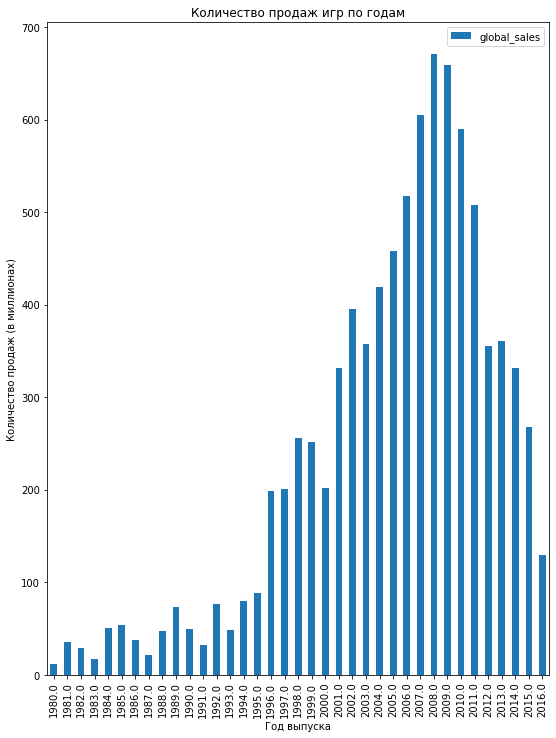

In [13]:
sales_for_year = df.pivot_table(values='global_sales', index='year_of_release', aggfunc='sum')
display(sales_for_year)
sales_for_year.plot(kind='bar', figsize=(9, 12))
plt.title('Количество продаж игр по годам')
plt.xlabel('Год выпуска')
plt.ylabel('Количество продаж (в миллионах)')
plt.show()

Рост с начала 2000-ых годов можно объяснить переходом игр в 3D, появлением новых технологичных игр и выходом консолей новых поколений, а вот спад после 2010 можно объяснить влиянием финансового кризиза 2008 года.
На графике видно, что по продажам самые удачные года были с 2007 по 2010, затем идет спад общих продаж. 2016 год оказался в 7 раз меньше 2008, стоит помнить, что информация за 2016 год у нас неполная, что и объясняет столь большой спад (в 2015 году продажи на 137 миллионов больше, разрыв более чем двукратный).


In [14]:
display(df['platform'].unique())

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [15]:
display(df.groupby('platform')['global_sales'].sum().sort_values(ascending=False).head())

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
Name: global_sales, dtype: float64

In [16]:
# Создадим функцию, которая поможет нам узнать как меняются продажи на платформах по годам
def platform_sales_by_years(platform):
    data_by_years = df.query('platform == @platform').groupby(['platform', 'year_of_release']).sum()['global_sales']
    data_by_years.plot(kind='bar', figsize=(9, 9))
    plt.title(f'Количество продаж игр на платфоре {platform} по годам')
    plt.xlabel('Год выпуска')
    plt.ylabel('Количество продаж (в миллионах)')
    plt.show()

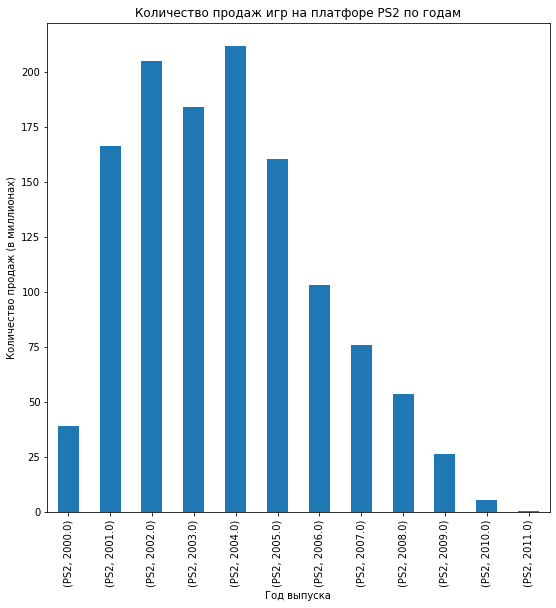

In [17]:
platform_sales_by_years('PS2')

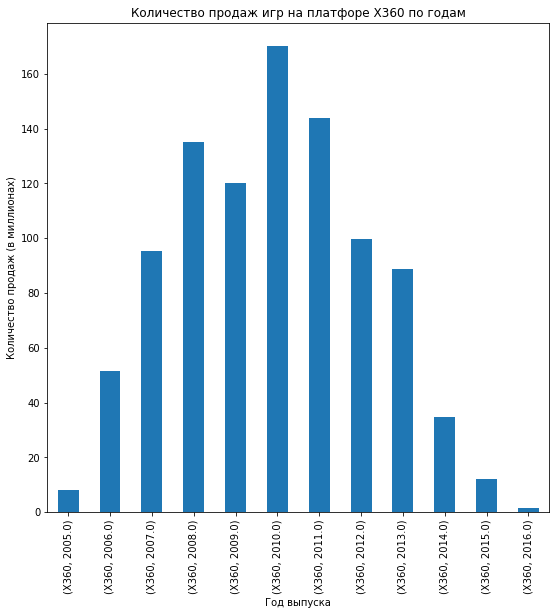

In [18]:
platform_sales_by_years('X360')

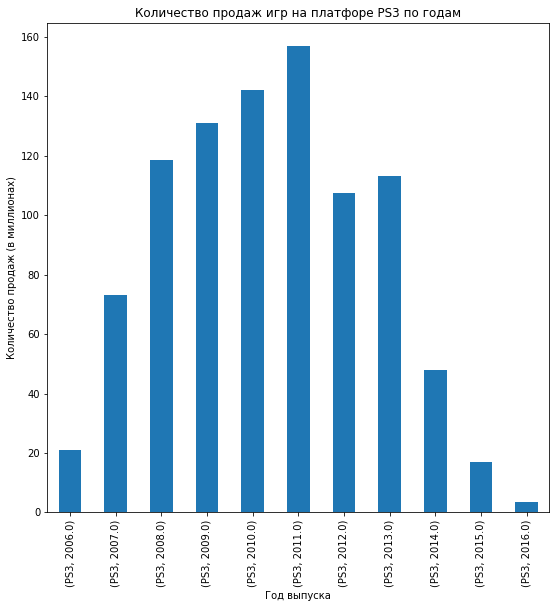

In [19]:
platform_sales_by_years('PS3')

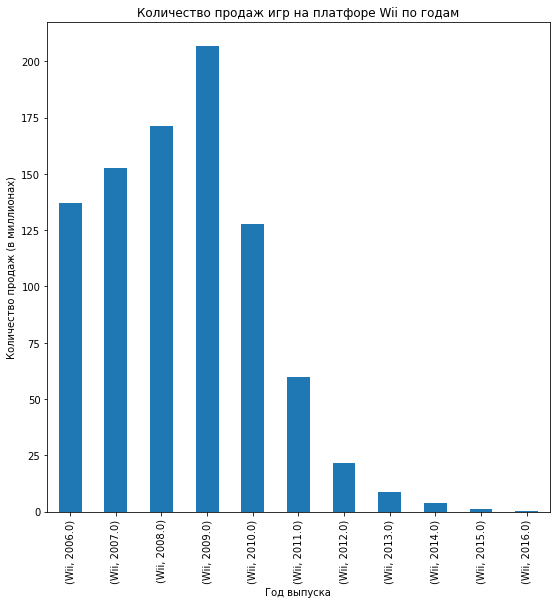

In [20]:
platform_sales_by_years('Wii')

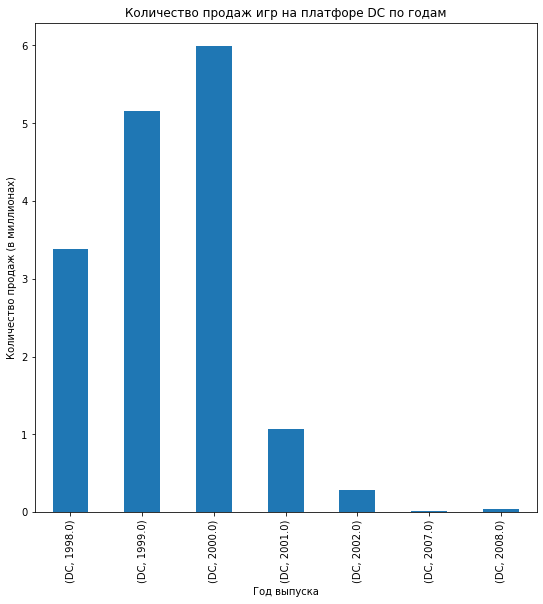

In [21]:
platform_sales_by_years('DC')

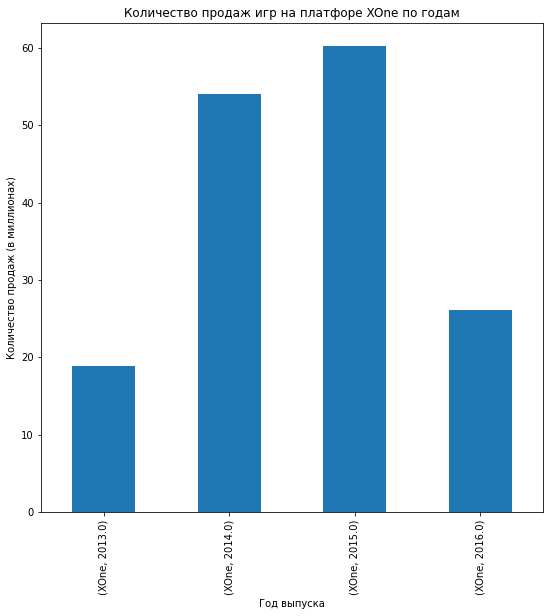

In [22]:
platform_sales_by_years('XOne')

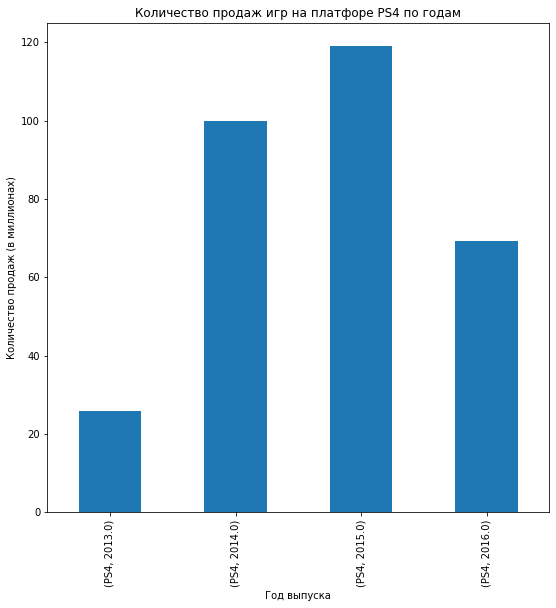

In [23]:
platform_sales_by_years('PS4')

Обращая внимание на графики, можно заметить, что период наибольшей популярности у платформ длится 3-4 года, в некоторых случаях 5 лет. В среднем платформы "живут" около 6-7 лет.

Так, платформа DC росла с 1998 года, была на пике в 2000 и практически в 6 раз упала в 2001. Wii росла с 2006 года и была на пике в 2010, после чего продажи стремительно стали падать.

Основываясь на данных результатах, в качестве актуального периода для прогнозирования на 2017 год выберем последние три года (2014, 2015, 2016).


In [24]:
df = df.query('year_of_release >= 2014')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   float64
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float32
 10  rating           940 non-null    object 
 11  global_sales     1689 non-null   float64
dtypes: float32(1), float64(7), object(4)
memory usage: 164.9+ KB


##### Анализ продаж по платформам

In [25]:
display(df['platform'].unique())

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV',
       'PSP'], dtype=object)

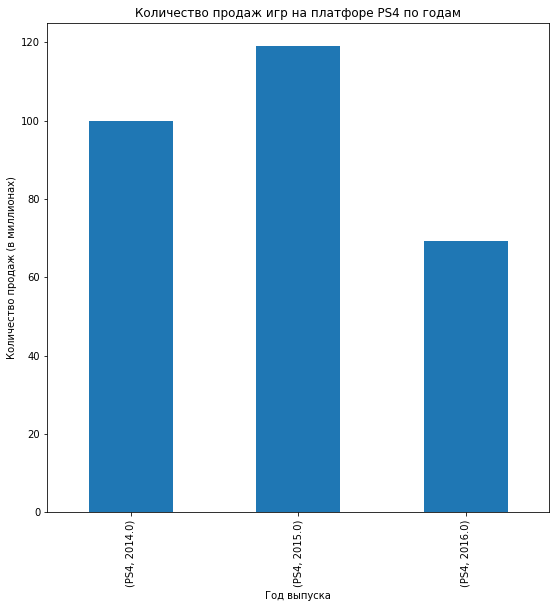

None

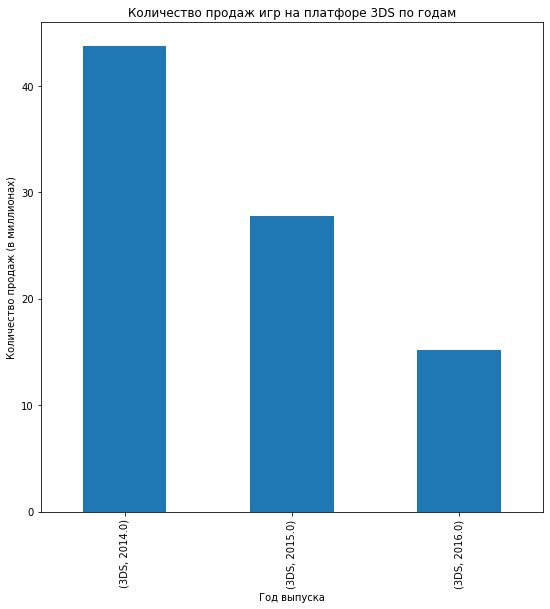

None

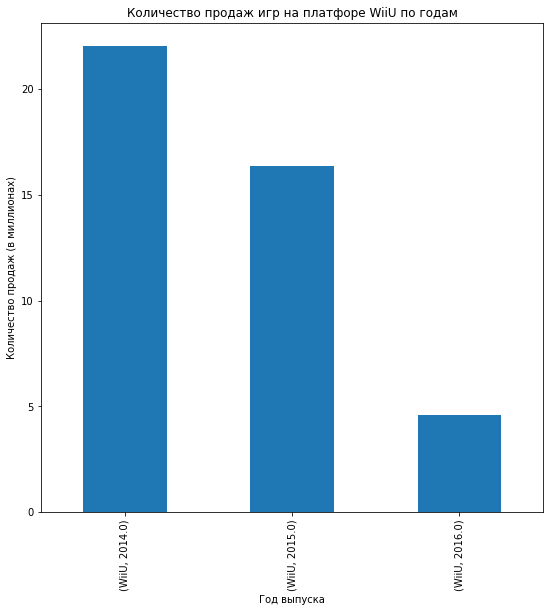

None

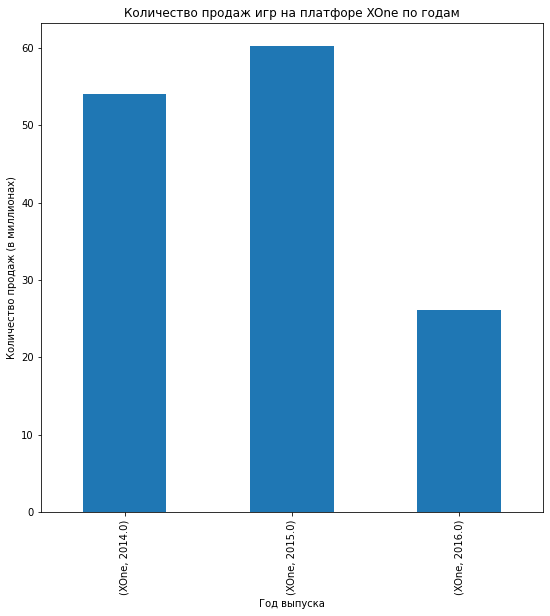

None

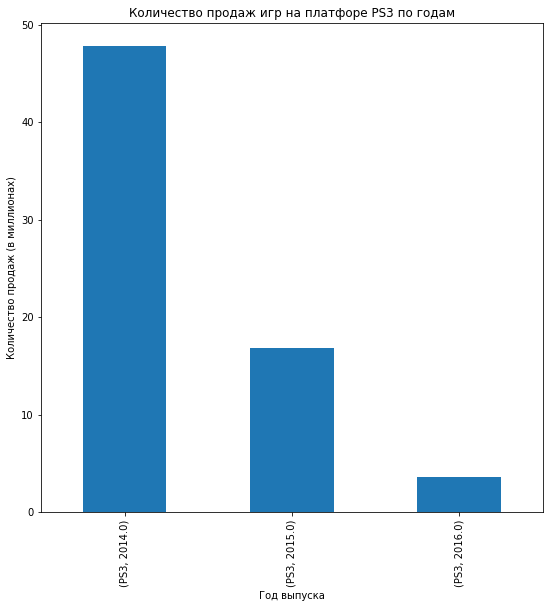

None

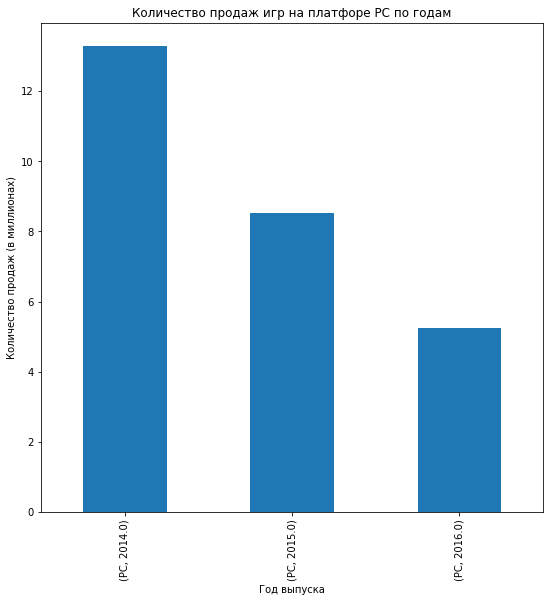

None

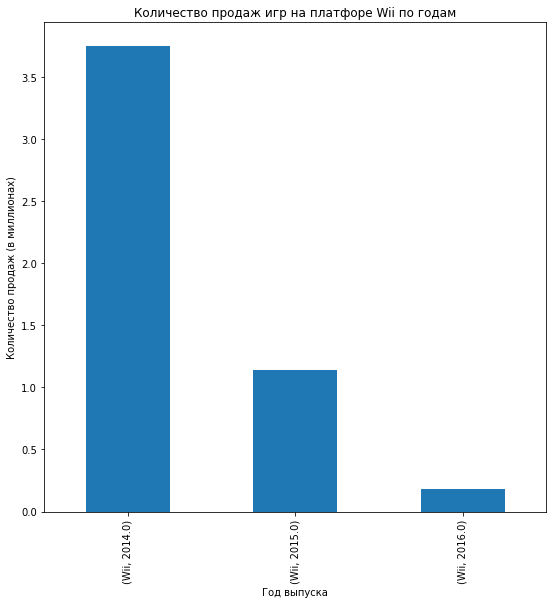

None

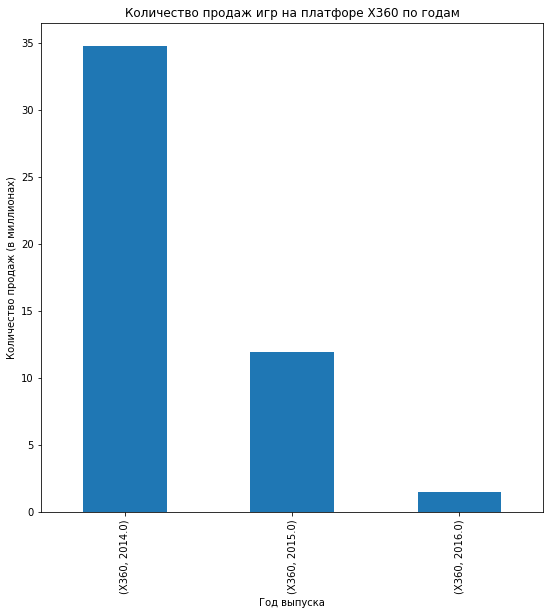

None

In [26]:
display(platform_sales_by_years('PS4'))
display(platform_sales_by_years('3DS'))
display(platform_sales_by_years('WiiU'))
display(platform_sales_by_years('XOne'))
display(platform_sales_by_years('PS3'))
display(platform_sales_by_years('PC'))
display(platform_sales_by_years('Wii'))
display(platform_sales_by_years('X360'))

Из пяти крупнейших платформ: PS4, XOne, 3DS, PS3, X360 - рост в 2015 году по сравнению с 2014 показали только PS4 и XOne. Продажи PS3 и XOne сократились в 2,5 раза, 3DS и WiiU - на 25%.

Таким образом, обозначим, как потенциально прибыльные, следующие платформы - PS4, XOne, 3DS и WiiU.

In [27]:
platform_sales = df.groupby(['platform', 'year_of_release'])['global_sales'].sum().reset_index()
platform_sales = platform_sales.query('platform in ["PS4", "XOne", "3DS", "WiiU"]')
# Определение потенциально прибыльных платформ
profitable_platforms = platform_sales.groupby('platform')['global_sales'].sum().sort_values(ascending=False)

print("Потенциально прибыльные платформы:\n", profitable_platforms)

Потенциально прибыльные платформы:
 platform
PS4     288.15
XOne    140.36
3DS      86.68
WiiU     42.98
Name: global_sales, dtype: float64


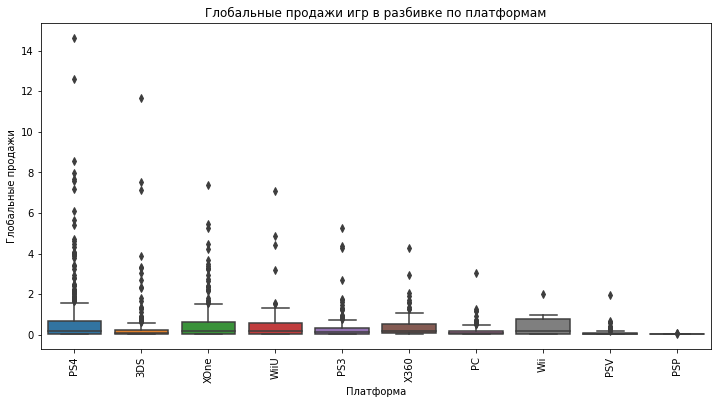

In [28]:
# Построим диаграмму размаха для глобальных продаж по платформам
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='platform', y='global_sales')
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.ylabel('Глобальные продажи')
plt.xlabel('Платформа')
plt.xticks(rotation=90)
plt.show()

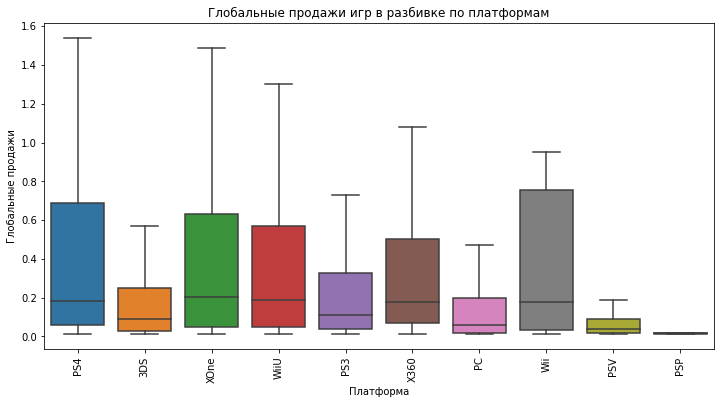

In [29]:
# Построим диаграмму размаха для глобальных продаж по платформам
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='platform', y='global_sales', showfliers=False)
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.ylabel('Глобальные продажи')
plt.xlabel('Платформа')
plt.xticks(rotation=90)
plt.show()

За выбранный период наибольшее медианное количество продаж показали платформы PS4, XOne, WiiU, Wii, X360. 

Результаты диаграммы размаха показывают, что на платформе медиана почти вдвое меньше, чем в выделенных вместе с ней PS4 и XOne, что заставляет усомниться в рекомендации данной платформы на 2017 год. В свою очередь остальные платформы из выбранных нами, как потенциально прибыльные, имеют достаточно похожую диаграмму.

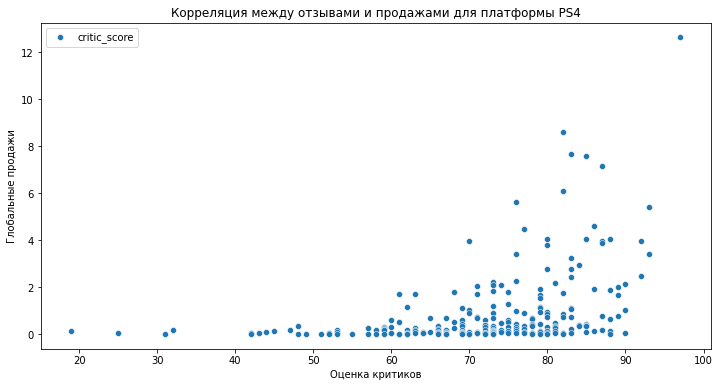

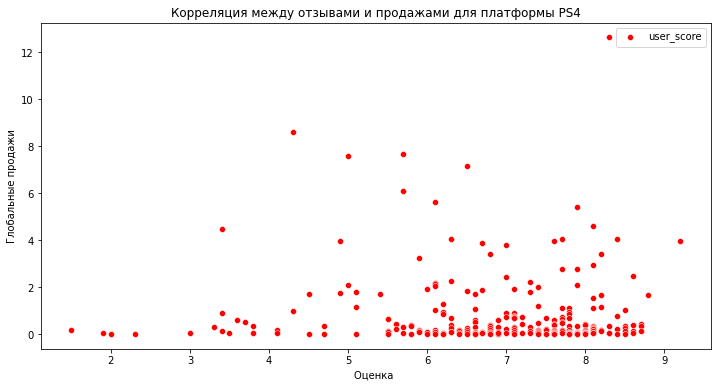

Корреляция между оценками критиков и продажами для PS4 : 0.40266141068104144
Корреляция между оценками пользователей и продажами для PS4 : -0.04013158973737978


In [30]:
# Влияние отзывов критиков и пользователей на продажи для популярной платформы

popular_platform = profitable_platforms.index[0]
platform_df = df[df['platform'] == popular_platform]

# Построение диаграммы рассеяния для оценок критиков
plt.figure(figsize=(12, 6))
sns.scatterplot(data=platform_df, x='critic_score', y='global_sales', label='critic_score')
plt.title(f'Корреляция между отзывами и продажами для платформы {popular_platform}')
plt.ylabel('Глобальные продажи')
plt.xlabel('Оценка критиков')
plt.show()

# Построение диаграммы рассеяния для оценок критиков
plt.figure(figsize=(12, 6))
sns.scatterplot(data=platform_df, x='user_score', y='global_sales', label='user_score', color='red')
plt.title(f'Корреляция между отзывами и продажами для платформы {popular_platform}')
plt.ylabel('Глобальные продажи')
plt.xlabel('Оценка ')
plt.show()
# Создадим функцию для расчета корреляции между отзывами и продажами
def corr_score_sales(number):
    popular_platform = profitable_platforms.index[number]
    platform_df = df[df['platform'] == popular_platform]
    
    critic_corr = platform_df[['critic_score', 'global_sales']].corr(method='pearson')
    user_corr = platform_df[['user_score', 'global_sales']].corr(method='pearson')
    
    print(f"Корреляция между оценками критиков и продажами для {popular_platform} : {critic_corr.loc['global_sales', 'critic_score']}")
    print(f"Корреляция между оценками пользователей и продажами для {popular_platform} : {user_corr.loc['global_sales', 'user_score']}")
    return

corr_score_sales(0)

In [31]:
display(corr_score_sales(1))
display(corr_score_sales(2))
display(corr_score_sales(3))

Корреляция между оценками критиков и продажами для XOne : 0.42867694370333287
Корреляция между оценками пользователей и продажами для XOne : -0.07038393161528549


None

Корреляция между оценками критиков и продажами для 3DS : 0.31411749286905155
Корреляция между оценками пользователей и продажами для 3DS : 0.21519327471370098


None

Корреляция между оценками критиков и продажами для WiiU : 0.3702014124808842
Корреляция между оценками пользователей и продажами для WiiU : 0.4079264698680881


None

**Выводы:**

Сравнение корреляций показывает, что оценка критиков имеет умеренную связь с количеством продаж (наибольшее значение 0.42 на платформе XOne). В свою очередь значение корреляции между оценкой пользователей и количеством продаж не дает говорить даже о наличии умеренной связи, исключение WiiU, где значение корреляции составило 0,4, но даже это позволяет говорить о наличии лишь умеренной связи и то более слабой, чем позволила бы нам делать какие-либо выводы.

##### Распределение по жанрам

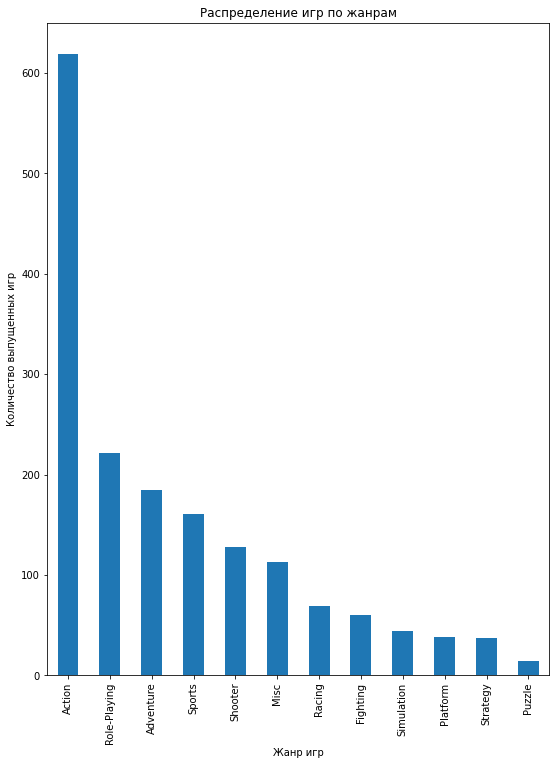

In [32]:
genre_allocation = df.pivot_table(values='platform', index='genre', aggfunc='count').sort_values(by='platform', ascending=False)
genre_allocation['platform'].plot(kind='bar', figsize=(9, 12))
plt.title('Распределение игр по жанрам')
plt.ylabel('Количество выпущенных игр')
plt.xlabel('Жанр игр')
plt.show()

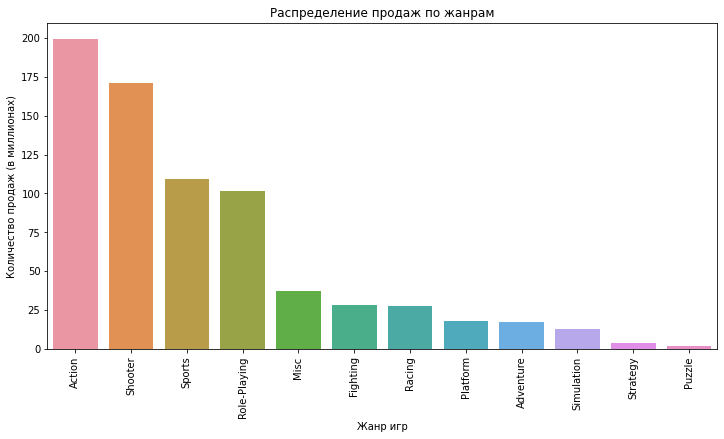

Жанры с наибольшими продажами:
 genre
Action          199.36
Shooter         170.94
Sports          109.48
Role-Playing    101.44
Misc             37.55
Name: global_sales, dtype: float64


In [33]:
# Распределение продаж игр по жанрам
genre_sales = df.groupby('genre')['global_sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_sales.index, y=genre_sales.values)
plt.title('Распределение продаж по жанрам')
plt.ylabel('Количество продаж (в миллионах)')
plt.xlabel('Жанр игр')
plt.xticks(rotation=90)
plt.show()

print("Жанры с наибольшими продажами:\n", genre_sales.head())

График количества выпущенных игр показывает, что наибольшее количество игр выпущено в жанре экшен, разница между первым и вторым местом около 400 игр, после жанра экшен идут ролевые игры, приключения, спорт, шутеры и misc. После этих шести жанров наблюдается резкий спад в два раза, на последнем месте здесь идут головоломки. Разница между количеством выпущенных игр жанра экшен и головоломка составляет около 600.

По графику с количеством продаж по жанрам можно заметить, что лидером также остаются экшен-игры, однако отрыв, который был более чем в два раза, сократился до 13%. Ролевые игры со второго места перешли на четвертое, шутеры с пятого места оказались на втором. Самое заметное изменение это игры-приключения занимая третье место по выпущенным играм, они оказались на четвертом месте с конца по количеству продаж, данный жанр игр мы точно не будем рассматривать как перспективный. 

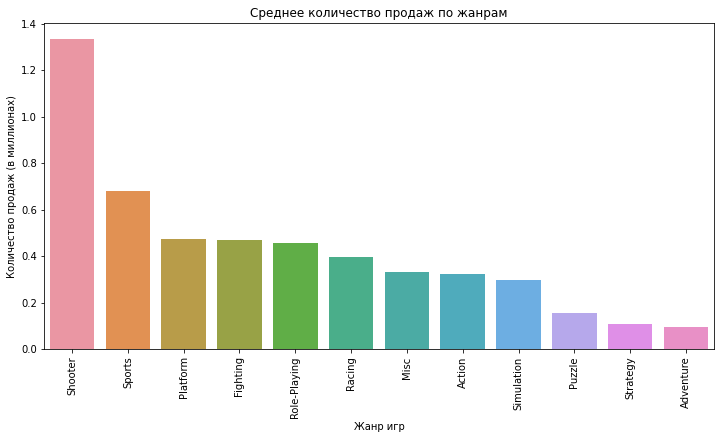

Жанры с самым высоким средним количеством продаж:
 genre
Shooter         1.335469
Sports          0.680000
Platform        0.476053
Fighting        0.470333
Role-Playing    0.459005
Name: global_sales, dtype: float64


In [34]:
# Распределение игр по жанрам, определим наиболее прибыльные жанры
genre_sales = df.groupby('genre')['global_sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_sales.index, y=genre_sales.values)
plt.title('Среднее количество продаж по жанрам')
plt.ylabel('Количество продаж (в миллионах)')
plt.xlabel('Жанр игр')
plt.xticks(rotation=90)
plt.show()

print("Жанры с самым высоким средним количеством продаж:\n", genre_sales.head())

Проанализировали, в дополнение к графикам с общим распределением игр и продаж по жанрам, график среднего количества продаж по жанрам, который подтверждает основные выводы:
1. Жанр экшен пусть и занимает первое место по продажам, но это происходит из-за большего количества выпущенных игр. Он отстает от лидера в средних продажах в 4 раза;
2. Наиболее перспективным жанром является шутер, он занимает второе место по продажам и имеет самое высокое среднее;
3. Также стоит присмотреться к жанру спорт;
4. По средним продажам в пятерку кроме лидеров вошли отстающие раньше платформеры и файтинги.


#### Шаг. Составление портрета пользователя для каждого региона

Построим графики распределения продаж игр в Северной Америке, Европе и Японии по платформам и жанрам. 

Построим график зависимости между продажами игры и рейтингом ESRB.

In [35]:
# Выведем на экран общее количество продаж в регионах
print('Общее количество продаж в Северной Америке:', df['na_sales'].sum())
print('Общее количество продаж в Европе:', df['eu_sales'].sum())
print('Общее количество продаж в Японии:', df['jp_sales'].sum())

Общее количество продаж в Северной Америке: 284.06000000000006
Общее количество продаж в Европе: 270.67999999999995
Общее количество продаж в Японии: 93.09


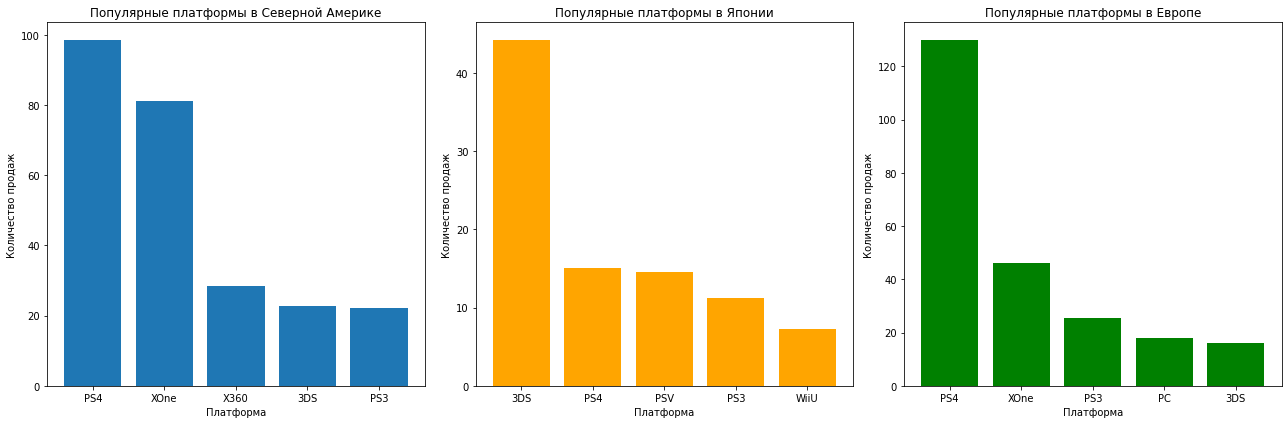

In [36]:
# Определим топ-5 платформ для каждого региона по продажам

top_platforms_na = df.groupby('platform').sum()['na_sales'].sort_values(ascending=False).head(5)
top_platforms_jp = df.groupby('platform').sum()['jp_sales'].sort_values(ascending=False).head(5)
top_platforms_eu = df.groupby('platform').sum()['eu_sales'].sort_values(ascending=False).head(5)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].bar(top_platforms_na.index, top_platforms_na.values)
axes[0].set_title('Популярные платформы в Северной Америке')
axes[0].set_xlabel('Платформа')
axes[0].set_ylabel('Количество продаж')

axes[1].bar(top_platforms_jp.index, top_platforms_jp.values, color='orange')
axes[1].set_title('Популярные платформы в Японии')
axes[1].set_xlabel('Платформа')
axes[1].set_ylabel('Количество продаж')

axes[2].bar(top_platforms_eu.index, top_platforms_eu.values, color='green')
axes[2].set_title('Популярные платформы в Европе')
axes[2].set_xlabel('Платформа')
axes[2].set_ylabel('Количество продаж')

plt.tight_layout()
plt.show()

Во Северной Америке и Европе почти 85% продаж приходится на пять крупнейших платформ, в Японии и вовсе 97%. Лидер по общим продажам PS4 представлен во всех трех регионах и занимает 1 и 2 позиции, XOne, занимает второе место в Америке и Европе, в Японии он находится за пределами 5 крупнейших платформ. 

Обращая внимание на распределение продаж по платформам:
1. В Америке 60% продаж приходится на PS4 и XOne, отрыв лидеров от остальных платформ 3-4 раза;
2. В Японии 3DS является лидером по продажам с практически трехкратным отрывом от следующей за ней PS4 и занимает почти 50% продаж;
3. В Европе на лидера - PS4 приходится почти 50% продаж, отрыв от остальных платформ более чем двукратный. 

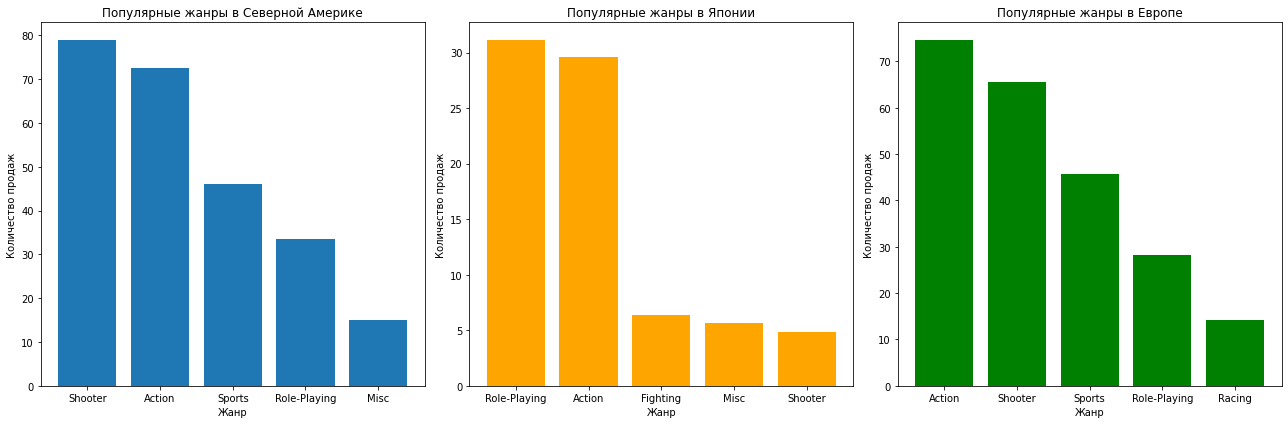

In [37]:
# Определим топ-5 жанров для каждого региона по продажам

top_genres_na = df.groupby('genre').sum()['na_sales'].sort_values(ascending=False).head(5)
top_genres_jp = df.groupby('genre').sum()['jp_sales'].sort_values(ascending=False).head(5)
top_genres_eu = df.groupby('genre').sum()['eu_sales'].sort_values(ascending=False).head(5)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].bar(top_genres_na.index, top_genres_na.values)
axes[0].set_title('Популярные жанры в Северной Америке')
axes[0].set_xlabel('Жанр')
axes[0].set_ylabel('Количество продаж')

axes[1].bar(top_genres_jp.index, top_genres_jp.values, color='orange')
axes[1].set_title('Популярные жанры в Японии')
axes[1].set_xlabel('Жанр')
axes[1].set_ylabel('Количество продаж')

axes[2].bar(top_genres_eu.index, top_genres_eu.values, color='green')
axes[2].set_title('Популярные жанры в Европе')
axes[2].set_xlabel('Жанр')
axes[2].set_ylabel('Количество продаж')

plt.tight_layout()
plt.show()

Как можно заметить на графиках, предпочтения в жанрах у пользователей из Северной Америки и Европы практически идентичны, лидируют экшен-игры и шутеры.

В Японии картина немного иная - на первое место выходят ролевые игры, экшен-игры заняли второе место, шутеры оказались на пятом месте, на третьем месте неожиданно появляются файтинги.

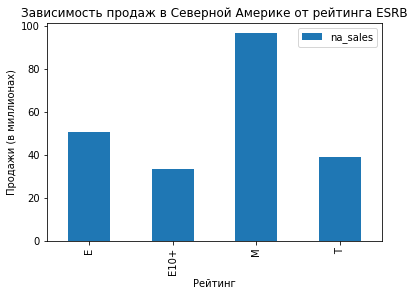

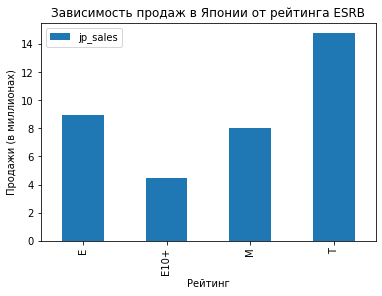

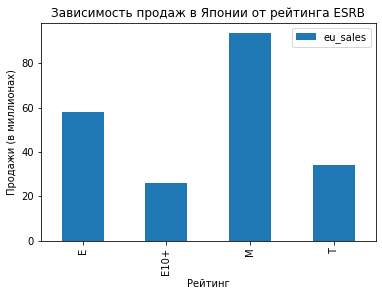

In [38]:
sales_rating_na = df.pivot_table(values='na_sales', index='rating', aggfunc='sum')
sales_rating_na.plot(kind='bar')
plt.title('Зависимость продаж в Северной Америке от рейтинга ESRB')
plt.ylabel('Продажи (в миллионах)')
plt.xlabel('Рейтинг')
plt.show()

sales_rating_jp = df.pivot_table(values='jp_sales', index='rating', aggfunc='sum')
sales_rating_jp.plot(kind='bar')
plt.title('Зависимость продаж в Японии от рейтинга ESRB')
plt.ylabel('Продажи (в миллионах)')
plt.xlabel('Рейтинг')
plt.show()

sales_rating_eu = df.pivot_table(values='eu_sales', index='rating', aggfunc='sum')
sales_rating_eu.plot(kind='bar')
plt.title('Зависимость продаж в Японии от рейтинга ESRB')
plt.ylabel('Продажи (в миллионах)')
plt.xlabel('Рейтинг')
plt.show()

In [39]:
print('Количество игр с рейтингом RP:', df.query('rating == "RP"')['rating'].count())
print('Количество игр с рейтингом E:', df.query('rating == "E"')['rating'].count())
print('Количество игр с рейтингом M:', df.query('rating == "M"')['rating'].count())
print('Количество игр с рейтингом E10+:', df.query('rating == "E10+"')['rating'].count())
print('Количество игр с рейтингом T:', df.query('rating == "T"')['rating'].count())

Количество игр с рейтингом RP: 0
Количество игр с рейтингом E: 219
Количество игр с рейтингом M: 265
Количество игр с рейтингом E10+: 185
Количество игр с рейтингом T: 271


Наименьшее количество продаж во всех трех регионах у игр с рейтингом E10+.

В Европе и Америке почти в равном соотношении первое место по продажам занимают игры с рейтингом M, второе - E, третье - T. В Японии же на первом месте игры с рейтингом T, на втором - E, на третьем, с небольшим отставанием, - М.

Однако стоит помнить, что в данных есть достаточное количество пропусков по рейтингу от ассоциации ESRB, т.к. данная ассоциация действует в основном в США, Мексике и Канаде, что может влиять на точность данных. Так в Европе существует ассоциация PEGI, а в Японии CERO.



#### Шаг. Проверка гипотез

На данном этапе проверим две гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
    1. H0 - средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC;
    2. H1 - средний пользовательский рейтинг платформы Xbox One не равен среднему пользовательскому рейтингу платформы PC;
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные
    1. H0 - средний пользовательский рейтинг игр жанра экшен равен среднему пользовательскому рейтингу игр жанра спорт;
    2. H1 - средний пользовательский рейтинг игр жанра экшен не равен среднему пользовательскому рейтингу игр жанра спорт;

Используется двусторонний t-test, поэтому альтернативные гипотезы сформулированы используя "не равно", параметр aplha задан на уровне 0.05, на мой взгляд это оптимальный вариант для двустороннего теста, так как эти 5% распределяются на 2,5% справа и слева от среднего.

In [40]:
data_xone = df.query('platform == "XOne"')
data_pc = df.query('platform == "PC"')
data_action = df.query('genre == "Action"')
data_sports = df.query('genre == "Sports"')

In [41]:
# Равны ли средние пользовательские рейтинги платформ Xbox One и PC?
alpha = 0.05
results1 = st.ttest_ind(data_xone['user_score'].dropna(), data_pc['user_score'].dropna())
print(results1.pvalue)
if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.10450648833224654
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value показывает, что нулевую гипотезу нельзя отвергать. Это значит, что средний пользовательский рейтинг платформ Xbox One и PC равен в большинстве случаев.

In [42]:
# Равны ли средние пользовательские рейтинг игр жанра экшен и спорт?
alpha = 0.05
results1 = st.ttest_ind(data_action['user_score'].dropna(), data_sports['user_score'].dropna())
print(results1.pvalue)
if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

2.871146400695882e-19
Отвергаем нулевую гипотезу


Полученное значение p-value показывает, что мы не можем отвергнуть гипотезу о разности рейтинга игр жанра экшен и спорт. p-value настолько низкое, что даже при alpha=0.01 гипотеза H0 не была бы отвергнута.

#### Общий вывод

В ходе данного исследования были сделаны следующие выводы:
1. В данных из открытых источников были обнаружены пропуски в столбцах critic_score, user_score, rating, которые не поддаются простому заполнению. ;
2. Актуальным периодом для прогнозирования на 2017 год выбран период с 2014 по 2016 год;
3. Сильной корреляции между оценками пользователей и критиков и количеством продаж игры не было обнаружено;
4. Потенциально прибыльными платформами считаем PS4 и XOne.
4. График количества выпущенных игр показывает, что наибольшее количество игр выпущено в жанре экшен, разница между первым и вторым местом около 400 игр, после жанра экшен идут ролевые игры, приключения, спорт и шутеры. 
    1. По графику количества продаж по жанрам видно, что лидером также остаются экшен-игры, однако отрыв, который был более чем в два раза, сократился до 26%. Самое заметное изменение это игры-приключения занимая третье место по выпущенным играм, они оказались на третьем месте с конца по количеству продаж, данный жанр игр мы точно не будем рассматривать как перспективный.
    2. Наиболее перспективным жанром является шутер, он занимает второе место по продажам и имеет самое высокое среднее. Жанр экшен пусть и занимает первое место по продажам, но это происходит из-за большего количества выпущенных игр.
5. Во всех регионах более 85% продаж приходится на пять крупнейших платформ. Лидер по общим продажам PS4 представлен во всех трех регионах и занимает 1 и 2 позиции, XOne, занимающий второе место лидирует в Америке и занимает второе место в Европе, в Японии он находится за пределами 5 крупнейших платформ. Обращая внимание на распределение продаж по платформам:
    1. В Америке 60% продаж приходится на PS4 и XOne, отрыв лидеров от остальных платформ 3-4 раза;
    2. В Японии 3DS является лидером по продажам с практически двукратным отрывом от следующей за ней PS4 и занимает почти 50% продаж;
    3. В Европе на лидера - PS4 приходится почти 50% продаж, отрыв от остальных платформ более чем двукратный.
6. Наименьшее количество продаж во всех трех регионах у игр с рейтингом E10+

Таким образом, в следующем году компании следует присмотреться к названным выше потенциально прибыльным платформам, также учитывая на какой регион они в большинстве своем направлены. Предпочтения в жанрах у пользователей из Северной Америки и Европы практически идентичны, лидируют экшен-игры и шутеры. Однако шутеры значительно превосходят экшен-игры по средним продажам, что добавляет жанру шутер потенциала.